In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 
import random
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.models import model_from_json
from matplotlib import pyplot
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from io import BytesIO
from skimage.transform import resize
from google.colab import files

Using TensorFlow backend.


Importing Convolutional Base from ResNet 50 for transfer learning 

In [0]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


94773248/94765736 [==============================] - 2s 0us/step


Loading Dataset from CIFAR-10, a module in tensorflow/keras
No preprocessing needed as data is already implemented. 
Dataset is split into images: train and test and label: train and test 
Dataset contains 50,000 images in training dataset across 10 classes and 10,000 images for testing dataset. 
Dataset contains 10 classes, compressed into 32 x 32 x 3 image.  
Images is scaled by 255 to retain RGB and Label is converted to categorical numpy array. 

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print(x_train.shape)
print(x_test.shape)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


Building Convolutional Neural Network Model via transfer learning. 
Sequential model is instantiated before adding the convolutional base, before adding dense layers and a final classifier layer. Transfer learning is done by tuning hyperparameters based on ResNet50. 
After adding the convolutional base, inputs must be flattened to obtain the correct size. 

In [0]:

model = models.Sequential()
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.5))
#model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=5 ,batch_size=32, validation_data=(x_test, y_test))
  

Epoch 1/5
1563/1563 [==============================] - 709s 453ms/step - loss: 0.1227 - acc: 0.7505 - val_loss: 0.0585 - val_acc: 0.8923
Epoch 2/5
1563/1563 [==============================] - 712s 455ms/step - loss: 0.0526 - acc: 0.9082 - val_loss: 0.0405 - val_acc: 0.9304
Epoch 3/5
1563/1563 [==============================] - 711s 455ms/step - loss: 0.0304 - acc: 0.9522 - val_loss: 0.0373 - val_acc: 0.9384
Epoch 4/5
1563/1563 [==============================] - 712s 456ms/step - loss: 0.0185 - acc: 0.9737 - val_loss: 0.0362 - val_acc: 0.9418
Epoch 5/5
1563/1563 [==============================] - 711s 455ms/step - loss: 0.0113 - acc: 0.9865 - val_loss: 0.0345 - val_acc: 0.9438


Saving Model Weights as JSON file to disk. 

In [0]:
#save to disk
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('/content/drive/My Drive/cifarmodel.h5') 

Model is evaluated using Test dataset and returns loss and accuracy. 

In [0]:
model.evaluate(x_test, y_test)


313/313 [==============================] - 38s 122ms/step - loss: 0.0345 - acc: 0.9438


[0.034454990178346634, 0.9437999725341797]

Displays Model Architecture

In [0]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_3 (UpSampling2 multiple                  0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 multiple                  0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 multiple                  0         
_________________________________________________________________
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
batch_normalization_2 (Batch multiple                  524288    
_________________________________________________________________
dense_2 (Dense)              multiple                 

Plot of Training loss and accuracy compared to Test loss and accuracy over epochs.

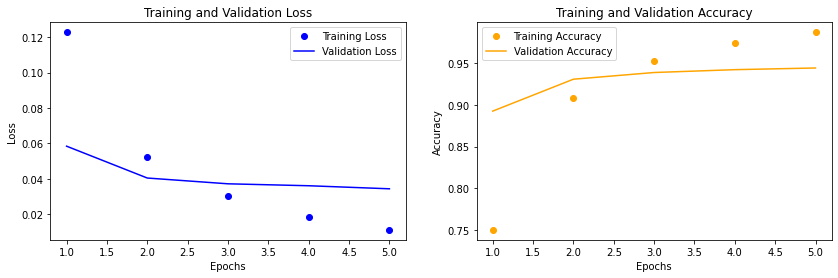

In [0]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training Accuracy', c='orange')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Displaying a sample of the testing dataset

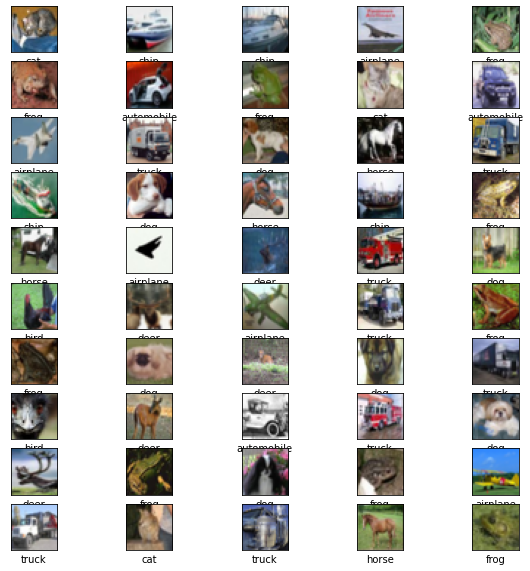

In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'] 

(img_train, label_train), (img_test, label_test) = cifar10.load_data()

num_images = 50 #Change this to display more images in multiples of 5 

plt.figure(figsize=(10,10))
for i in range(num_images):
    plt.subplot(num_images/5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_test[i], cmap=plt.cm.binary) #Change this from test to train
    plt.xlabel(class_names[label_test[i][0]]) #Change this from test to train
plt.show()

Loading trained CNN model in JSON file and using the model to predict each of the labels for the above number of images. 

In [0]:
# Load trained CNN model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('/content/drive/My Drive/cifarmodel.h5')
  
indices = np.argmax(model.predict(x_test[:num_images]),1) #Change this from test to train but use x_train or x_test
print("Predicted labels for test images displayed above:")
print([class_names[x] for x in indices]) 

lst1 = []
a= 0

for i in range(num_images):
  lst1.append(class_names[label_test[i][0]])  #Change this from test to train
lst2 = [class_names[x] for x in indices]

for i in range(num_images): 
  if lst2[i] == lst1[i]: 
    a+=1
  else: continue
print("CNN Model can predict", a ,"correctly out of", num_images ,"test images.")

Predicted labels for test images displayed above:
['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile', 'airplane', 'truck', 'dog', 'horse', 'truck', 'ship', 'dog', 'horse', 'ship', 'frog', 'horse', 'airplane', 'deer', 'truck', 'dog', 'cat', 'deer', 'airplane', 'truck', 'frog', 'frog', 'dog', 'deer', 'dog', 'truck', 'dog', 'deer', 'automobile', 'truck', 'dog', 'deer', 'frog', 'dog', 'frog', 'airplane', 'truck', 'cat', 'automobile', 'horse', 'frog']
CNN Model can predict 47 correctly out of 50 test images.


Selecting a random image from the above sample and plots the Top K classes as predictions and probabilities from the model. 

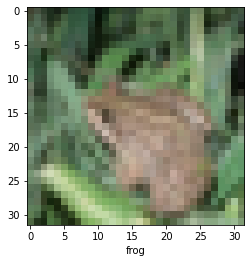

Top 3 classes are: frog and probability is 0.9986368
Top 3 classes are: automobile and probability is 0.00052069756
Top 3 classes are: deer and probability is 0.0002693104


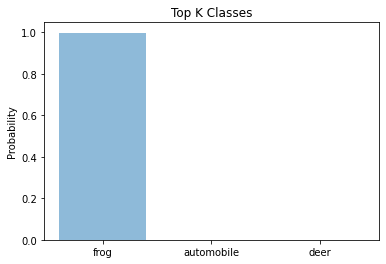

In [0]:
top_k = 3 #Change this value for more k 
n = random.randint(0,num_images) #Change this number to display any of the above nth images
lst = [] 
idx = []
top_values, top_indices = tf.nn.top_k(model.predict(x_test[n-1:n]), k=top_k) 
plt.imshow(img_test[n-1], cmap=plt.cm.binary) #Change this from test to train
plt.xlabel(class_names[label_test[n-1][0]])
plt.show() 

for i in top_indices[0]:
  print("Top",top_k, "classes are:" ,class_names[i], "and probability is",model.predict(x_test[n-1:n])[0][i])
  lst.append(model.predict(x_test[n-1:n])[0][i])
  idx.append(class_names[i])

objects = tuple(idx)
y_pos = np.arange(len(objects))
performance = lst
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Probability')
plt.title('Top K Classes')
plt.show()

This code cell only runs in Google Colabs, upload an image in JPEG format and ensure the uploaded name tallies with the name in the string. Displays the image uploaded.

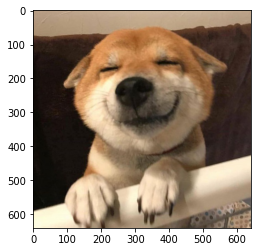

In [7]:
#uploaded = files.upload() 
#im = Image.open(BytesIO(uploaded['doggo1.jpg'])) #Update JPG name file as you upload the image 
im = Image.open('/content/drive/My Drive/doggo3.jpg')
array= np.array(im) 
array = array /255  
array = cv2.resize(array, dsize=(32,32), interpolation=cv2.INTER_CUBIC) 
#plt.imshow(array) 
plt.imshow(im)

Plot and displays Top K classes and probabilities based on the model prediction of the above uploaded image.

In [8]:
top_k = 3 #Change this value for more k 
#array = np.swapaxes(array,0,1) ### Try Uncommenting this line if predictions are wrong especially if object in image displayed is landscape. 
array = np.resize(array,(1,32,32,3)) 
lst1=[]
lst2=[]
pred = np.argmax(model.predict(array),1) 
print("Predicted class for uploaded image is:",str([class_names[x] for x in pred]))
top_values, top_indices = tf.nn.top_k(model.predict(array), k=top_k) 
for i in top_indices[0]:
  print("Top",top_k, "classes are:" ,class_names[i], "and probability is",model.predict(array)[0][i])
  lst1.append(model.predict(array)[0][i])
  lst2.append(class_names[i])
objects = tuple(lst2)
y_pos = np.arange(len(objects))
performance = lst1
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Probability')
plt.title('Top K Classes')
plt.show()


NameError: ignored

In [6]:
def old_macdonald(x): 
    lst1= []
    lst2= []
    lst1= x[0:3]
    lst2= x[3:]
    return lst1.capitalize() + lst2.capitalize()

old_macdonald('yaokuan')

'YaoKuan'

In [7]:
def old_macdonald(x): 
    return x[0:3].capitalize() + x[3:].capitalize()

old_macdonald('yaokuan')    

'YaoKuan'